## Shap with the Titanic
---
* ### Ingrid Arbieto Nelson

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Shap-with-the-Titanic" data-toc-modified-id="Shap-with-the-Titanic-1">Shap with the Titanic</a></span><ul class="toc-item"><li><span><a href="#Ingrid-Arbieto-Nelson" data-toc-modified-id="Ingrid-Arbieto-Nelson-1.1">Ingrid Arbieto Nelson</a></span></li><li><span><a href="#the-Data" data-toc-modified-id="the-Data-1.2">the Data</a></span></li></ul></li><li><span><a href="#Starter-Code" data-toc-modified-id="Starter-Code-2">Starter Code</a></span></li><li><span><a href="#SHAP" data-toc-modified-id="SHAP-3">SHAP</a></span><ul class="toc-item"><li><span><a href="#Summary-Plot-for-Passengers-that-Survived" data-toc-modified-id="Summary-Plot-for-Passengers-that-Survived-3.1">Summary Plot for Passengers that Survived</a></span></li><li><span><a href="#Shap-Summary-Plot-Interpretation:" data-toc-modified-id="Shap-Summary-Plot-Interpretation:-3.2">Shap Summary Plot Interpretation:</a></span></li></ul></li></ul></div>

For this assignment you will be fitting a machine learning model to predict survivors of the titanic.
* This assignment is focused on working with Shap, so we have provided the code up through the modeling process.

After fitting the model, use Shap to create:
* A summary plot for passengers that Survived.
* In a markdown cell below, interpret the top 5 most important features (according to shap).
   * Do these results make sense based on what you know about the Titanic?

### the Data
* [Share URL](https://drive.google.com/file/d/1zP14pOhU5dd1pNc6JnhF-XJOzuUmtGxI/view?pli=1)
* Original Source & Data Dictionary: https://www.kaggle.com/competitions/titanic/data
* Direct URL: https://docs.google.com/spreadsheets/d/e/2PACX-1vR9Yhcch85ziIad4CyZQqLtYijHgsuENLfyC0YAXlajVbSC7U7s3CUUsfG-OYIKOjTI9DdKZH1xMs3a/pub?output=csv



## Starter Code

In [10]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)

In [12]:
def evaluate_classification(model, X_train,y_train,X_test,y_test,
                            normalize='true',cmap='Blues', figsize=(10,5)):
    header="\tCLASSIFICATION REPORT"
    dashes='--'*40
    print(f"{dashes}\n{header}\n{dashes}")
    ## training data
    print('[i] Training Data:')
    y_pred_train = model.predict(X_train)
    report_train = metrics.classification_report(y_train, y_pred_train)
    print(report_train)
    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_train,y_train,
                                                  normalize=normalize,
                                                   cmap=cmap,ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_train,y_train,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    
    fig.tight_layout()
    plt.show()
     
    print(dashes)
    ## test data
    print(f"[i] Test Data:")
    y_pred_test = model.predict(X_test)
    report_test = metrics.classification_report(y_test, y_pred_test)
    print(report_test)
    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,
                                                  normalize=normalize,
                                                   cmap=cmap, ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_test,y_test,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    fig.tight_layout()
    plt.show()


In [2]:
file = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR9Yhcch85ziIad4CyZQqLtYijHgsuENLfyC0YAXlajVbSC7U7s3CUUsfG-OYIKOjTI9DdKZH1xMs3a/pub?output=csv'
df= pd.read_csv(file,index_col=0)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
## Make x and y variables
drop_feats = ["Name","Ticket","Cabin"]
y = df['Survived'].copy()
X = df.drop(columns=['Survived',*drop_feats]).copy()


In [4]:
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)

In [5]:
## Preprocessing + ColumnTransformer
## make categorical & numeric selectors
cat_sel = make_column_selector(dtype_include='object')
num_sel = make_column_selector(dtype_include='number')
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000262C1EBD370>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000262C1EBD3D0>)],
                  verbose_feature_names_out=False)

In [8]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)

X_train_df.head(3)

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_MISSING,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
255,3.0,41.00,0.0,2.0,20.2125,0.0,0.0,0.0,0.0,1.0
470,3.0,0.75,2.0,1.0,19.2583,0.0,1.0,0.0,0.0,0.0
813,2.0,35.00,0.0,0.0,10.5000,1.0,0.0,0.0,0.0,1.0


In [17]:
X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_MISSING,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
355,3.0,30.314472,0.0,0.0,7.225,1.0,1.0,0.0,0.0,0.0
519,2.0,36.000000,1.0,0.0,26.000,0.0,0.0,0.0,0.0,1.0
814,3.0,6.000000,4.0,2.0,31.275,0.0,0.0,0.0,0.0,1.0


**Next, evaluate your model's performance on the training and test data and then apply Shap!**

In [11]:
## fit random forest
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_df,y_train)

RandomForestClassifier()

--------------------------------------------------------------------------------
	CLASSIFICATION REPORT
--------------------------------------------------------------------------------
[i] Training Data:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       419
           1       0.98      0.97      0.98       249

    accuracy                           0.98       668
   macro avg       0.98      0.98      0.98       668
weighted avg       0.98      0.98      0.98       668



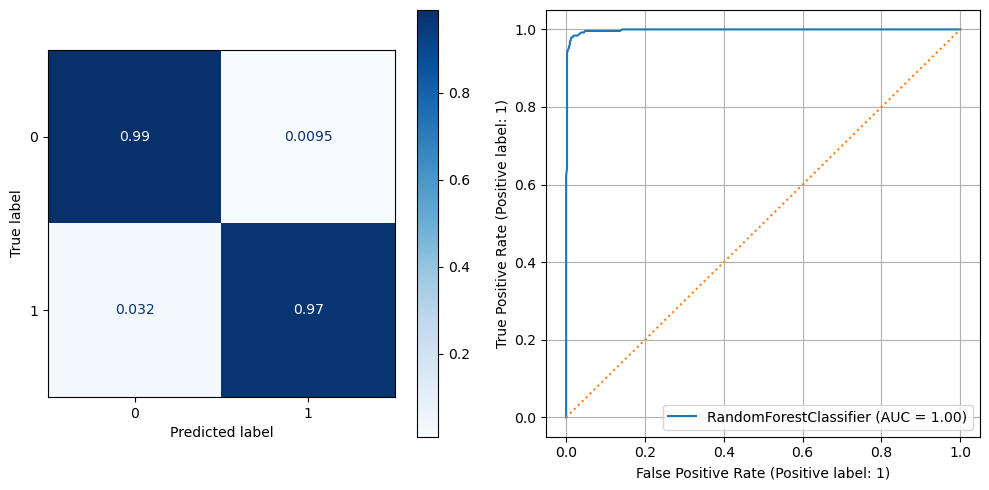

--------------------------------------------------------------------------------
[i] Test Data:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       130
           1       0.81      0.83      0.82        93

    accuracy                           0.85       223
   macro avg       0.84      0.84      0.84       223
weighted avg       0.85      0.85      0.85       223



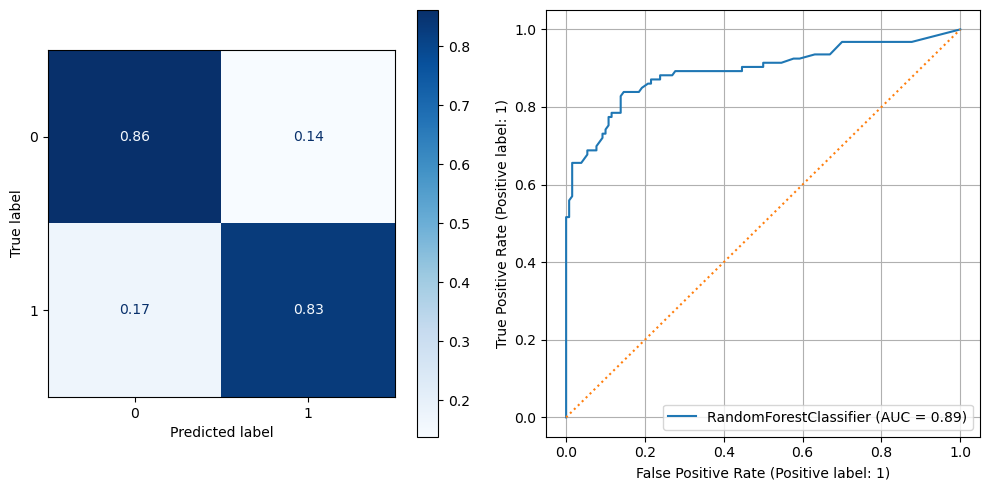

In [13]:
evaluate_classification(rf_clf,X_train_df,y_train, X_test_df,y_test)

## SHAP

In [14]:
# Import shap and initialize javascript:
import shap
shap.initjs()

In [15]:
X_shap = shap.sample(X_test_df,nsamples=400,random_state=321)
X_shap

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_MISSING,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
355,3.0,30.314472,0.0,0.0,7.2250,1.0,1.0,0.0,0.0,0.0
519,2.0,36.000000,1.0,0.0,26.0000,0.0,0.0,0.0,0.0,1.0
814,3.0,6.000000,4.0,2.0,31.2750,0.0,0.0,0.0,0.0,1.0
387,3.0,1.000000,5.0,2.0,46.9000,1.0,0.0,0.0,0.0,1.0
490,3.0,9.000000,1.0,1.0,15.9000,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
599,3.0,30.314472,0.0,0.0,7.2250,1.0,1.0,0.0,0.0,0.0
740,3.0,30.314472,0.0,0.0,7.8958,1.0,0.0,0.0,0.0,1.0
253,1.0,62.000000,0.0,0.0,26.5500,1.0,0.0,0.0,0.0,1.0


In [18]:
## get the corresponding y-values
y_shap = y_test.loc[X_shap.index]
y_shap 

PassengerId
355    0
519    1
814    0
387    0
490    1
      ..
599    0
740    0
253    0
382    1
536    1
Name: Survived, Length: 223, dtype: int64

In [19]:
explainer = shap.Explainer(rf_clf)
explainer

In [20]:
## Getting the shap values
shap_values = explainer(X_shap,y_shap)
shap_values.shape

(223, 10, 2)

In [21]:
shap_vals_Survived = shap_values[:,:,1]
shap_vals_Survived

.values =
array([[-6.33526011e-02, -2.90542328e-02, -5.01268267e-03, ...,
        -1.09694400e-05,  4.05684574e-03,  2.46934472e-02],
       [ 8.49621800e-02,  2.89058796e-02, -8.37068522e-03, ...,
        -1.18998865e-05, -1.53820161e-03, -5.71726943e-03],
       [-1.01234194e-01,  2.48630805e-01, -6.53712299e-02, ...,
        -9.85161736e-06,  3.18214397e-03, -4.24926477e-03],
       ...,
       [ 9.85832214e-02, -2.30981234e-01, -1.33445908e-02, ...,
        -2.97743746e-04,  1.25678999e-03, -6.69439882e-03],
       [-5.93256379e-02,  1.56884664e-01,  3.27197532e-02, ...,
        -7.89859050e-06,  9.11090728e-03, -4.37138830e-03],
       [ 7.82827000e-02,  1.38682917e-01,  2.70757203e-02, ...,
        -1.16258818e-05,  4.04008261e-03, -2.00506604e-03]])

.base_values =
array([0.37199102, 0.37199102, 0.37199102, 0.37199102, 0.37199102,
       0.37199102, 0.37199102, 0.37199102, 0.37199102, 0.37199102,
       0.37199102, 0.37199102, 0.37199102, 0.37199102, 0.37199102,
       0.3719910

### Summary Plot for Passengers that Survived

* In a markdown cell below, interpret the top 5 most important features (according to shap).
* Do these results make sense based on what you know about the Titanic?

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


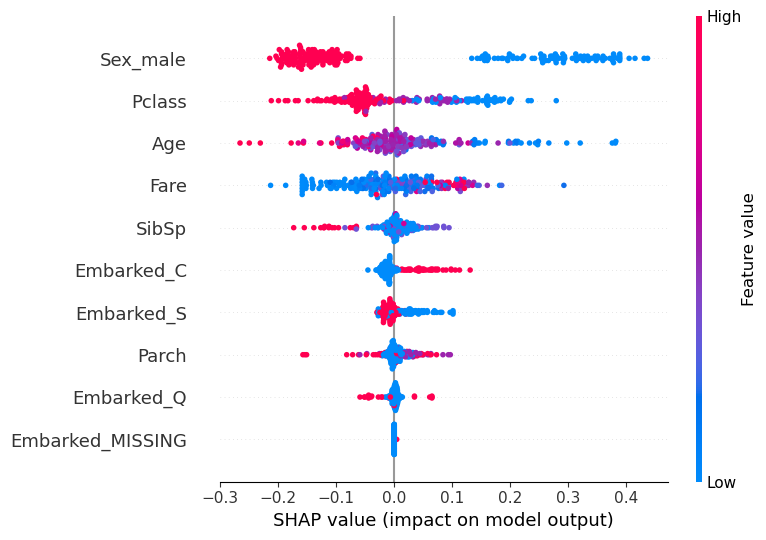

In [22]:
shap.summary_plot(shap_vals_Survived,X_shap)

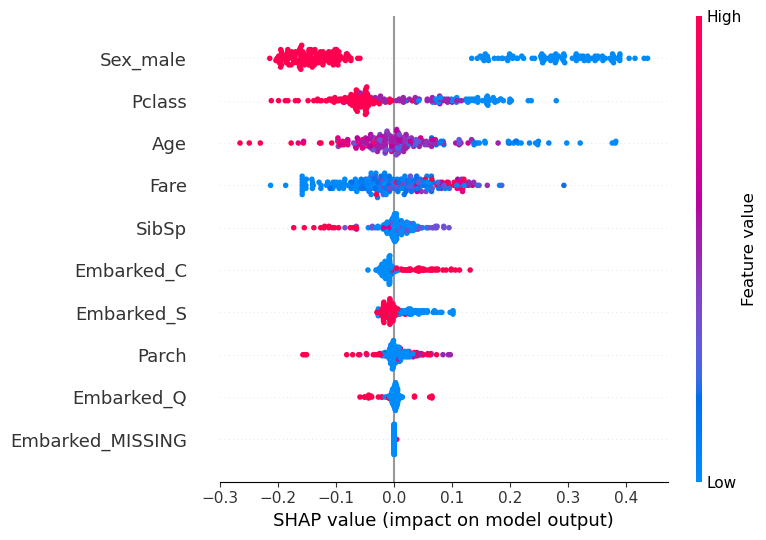

In [24]:
fig, ax = plt.subplots()
shap.summary_plot(shap_vals_Survived,X_shap)
ax.set_title('Summary Plot - Class=Survived');
fig.savefig('images/summary_plot_titanic.png')

### Shap Summary Plot Interpretation:

* Sex_male:

   - Being male decreased the likelihood of being predicted to be a Survivor
* Fare:

   - The higher the fare, the more likely the model will predict they will Survive.
* Pclass:

   - The better the passenger class (lower is better) the more likely the model will predict they will Survive.
* Age:

   - The older the passenger, the more likely the model will predict them to die.
* SibSp:

   - The more family members, the less likely the model will predict them to Survive.

These make intuitive sense due to "Women and children first", as well as first class passengers being prioritized.